# Modelling of Georgia

## Initial Loading of Packages and data

Small naming correction made for spelling mistakes

In [5]:
%cd ..

g:\My Drive\Professional_Backups\Professional\Erdós\AP-Outcomes-to-University-Metrics


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
# Visualizers
import shap
import matplotlib.pyplot as plt

In [14]:
training=pd.read_pickle('data/GA_pickled/training.pkl')
testing=pd.read_pickle('data/GA_pickled/testing.pkl')

In [15]:
training=training.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'})
testing=testing.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant'})

In [16]:
# Features are obtained from georga_models
features=['population',
 'per_capita_income',
 'closest_five_r1r2_avg',
 'closest_five_public_avg',
 'closest_five_private_nfp_avg',
 'closest_five_landgrant_avg',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_enrollment_landgrant',
 'closest_five_avg_enrollment_stem',
 'closest_five_avg_dormrooms_r1r2',
 'closest_five_avg_dormrooms_public',
 'closest_five_avg_dormrooms_private_nfp',
 'closest_five_avg_dormrooms_landgrant',
 'closest_five_avg_dormrooms_stem']

training.per_capita_income=training.per_capita_income.astype(int)

training[features].head()

,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrant_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrant,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
293,41978,71183,72.680652,42.290867,58.439987,149.334964,72.680652,29515.6,16912.8,1395.8,27932.4,29515.6,6238.8,2204.0,391.6,6317.4,6238.8
146,65314,42057,163.555197,42.536561,107.162330,248.064831,187.704795,21782.2,9207.6,4225.0,27275.0,20912.8,4544.6,1876.2,1810.0,6133.0,4659.0
231,25522,37629,64.752872,45.445749,49.345304,142.383194,64.752872,22914.0,8495.2,2734.2,22160.2,22914.0,4832.0,865.6,900.0,5104.8,4832.0
247,27355,51885,74.295844,45.544418,45.621410,164.414237,80.324044,29745.0,20450.8,2400.4,22676.4,29515.6,5252.0,1771.6,532.8,5996.8,6238.8
168,28382,38448,92.409744,34.776505,60.783191,151.964001,92.409744,22858.8,9818.8,2734.2,22160.2,22858.8,5082.8,1107.8,900.0,5104.8,5082.8


In [17]:
x_train = training.drop(['COUNTY','SCHOOL_DSTRCT_NM', 'TEST_CMPNT_TYP_NM','EXAM_COUNT','EXAMS_3_OR_ABOVE','PERCENT_3_OR_ABOVE','Year','Latitude','Longitude','Year'],axis=1)
y_train = training[['PERCENT_3_OR_ABOVE']]
X_train = sm.add_constant(x_train)
unimetric_train = X_train.drop(['population','per_capita_income'],axis=1)
X_train.head()

,const,population,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrant_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrant,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem,per_capita_income
293,1.0,41978,72.680652,42.290867,58.439987,149.334964,72.680652,29515.6,16912.8,1395.8,27932.4,29515.6,6238.8,2204.0,391.6,6317.4,6238.8,71183
146,1.0,65314,163.555197,42.536561,107.162330,248.064831,187.704795,21782.2,9207.6,4225.0,27275.0,20912.8,4544.6,1876.2,1810.0,6133.0,4659.0,42057
231,1.0,25522,64.752872,45.445749,49.345304,142.383194,64.752872,22914.0,8495.2,2734.2,22160.2,22914.0,4832.0,865.6,900.0,5104.8,4832.0,37629
247,1.0,27355,74.295844,45.544418,45.621410,164.414237,80.324044,29745.0,20450.8,2400.4,22676.4,29515.6,5252.0,1771.6,532.8,5996.8,6238.8,51885
168,1.0,28382,92.409744,34.776505,60.783191,151.964001,92.409744,22858.8,9818.8,2734.2,22160.2,22858.8,5082.8,1107.8,900.0,5104.8,5082.8,38448


## initial models

In [19]:
full_model = sm.OLS(y_train,X_train).fit()
unimetric_model = sm.OLS(y_train,unimetric_train).fit()
nonuni_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income + population', data=training).fit()
unidistance_model = smf.ols('PERCENT_3_OR_ABOVE ~ closest_five_r1r2_avg + closest_five_public_avg + closest_five_private_nfp_avg + closest_five_landgrant_avg + closest_five_stem_avg', data = training).fit()
pci_model=smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income', data =training).fit()

In [20]:
f_test_nonuni = full_model.compare_f_test(nonuni_model)
f_test_unimetric = full_model.compare_f_test(unimetric_model)
f_test_unidistance = unimetric_model.compare_f_test(unidistance_model)
print("p-value of full compared to non-university metric model:", f_test_nonuni[1])
print("p-value of full compared to university metric model:", f_test_unimetric[1])
print("p-value of university metric compared to university distance model:", f_test_unidistance[1])

p-value of full compared to non-university metric model: 1.9001504827826906e-14
p-value of full compared to university metric model: 1.7060664793494479e-15
p-value of university metric compared to university distance model: 1.4307461627854292e-06


In [21]:
uni_features = [x for x in features if "closest_five" in x]
nonuni_features = [x for x in features if "closest_five" not in x]
features_wo_dormrooms = [x for x in features if "dormrooms" not in x]
coordinates = ['Latitude','Longitude']

In [22]:
#Full
fullmodel = LinearRegression()
fullmodel.fit(training[features],training['PERCENT_3_OR_ABOVE'])
# University
unimodel = LinearRegression()
unimodel.fit(training[uni_features],training['PERCENT_3_OR_ABOVE'])
# Population-income
nonunimodel = LinearRegression()
nonunimodel.fit(training[nonuni_features],training['PERCENT_3_OR_ABOVE'])
# No silly dorms
wodormrooms_model = LinearRegression()
wodormrooms_model.fit(training[features_wo_dormrooms],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [23]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the "take the mean and call it a day" model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for nonuni model
    nonuni_lr = LinearRegression()
    
    nonuni_lr.fit(georga_train[nonuni_features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], nonuni_lr.predict(georga_holdout[nonuni_features]))
    
    ## Fit and get ho mse for uni model
    uni_lr = LinearRegression()

    uni_lr.fit(georga_train[uni_features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], uni_lr.predict(georga_holdout[uni_features]))

    ## Fit and get ho mse for no dorm rooms model

    nodorm_lr = LinearRegression()

    nodorm_lr.fit(georga_train[features_wo_dormrooms],georga_train['PERCENT_3_OR_ABOVE'])

    rmses[4, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], nodorm_lr.predict(georga_holdout[features_wo_dormrooms]))

    i = i+1


In [24]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"nonuni model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"uni model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"no dorm rooms model Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")

Baseline Avg. CV RMSE: 20.056081634450265 and STD: 0.9866282517775079
fullmodel Avg. CV RMSE: 16.571892724823066 and STD: 1.399983480576182
nonuni model Avg. CV RMSE: 18.234414383298414 and STD: 1.2040356415506979
uni model Avg. CV RMSE: 17.786479943538176 and STD: 1.3376183005621098
no dorm rooms model Avg. CV RMSE: 17.06558897633569 and STD: 1.2493068835653667


### Results initial fitting

Full performs best.

## PCA

In [25]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(training[features])

In [26]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)

In [27]:
print(f'original feature size: {training_scaled.shape[1]}')
print(f'new feature size: {training_pca.shape[1]}')

original feature size: 17
new feature size: 9


### PCA results

Similar feature reduction is seen as to WI

## Ridge vs PCA vs Full Models

In [28]:
pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

In [29]:
pca_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])
ridge_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('ridge', Ridge())])

In [30]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for PCA model
    pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
    
    pca_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], pca_pipe.predict(georga_holdout[features]))
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(georga_holdout[features]))

    i = i+1


In [31]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"PCA model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 20.056081634450265 and STD: 0.9866282517775079
fullmodel Avg. CV RMSE: 16.571892724823066 and STD: 1.399983480576182
PCA model Avg. CV RMSE: 17.098642656092196 and STD: 1.2526575647197526
Ridge model Avg. CV RMSE: 16.560872363874488 and STD: 1.3918842111792111


### Results of comparison

Ridge model is nearly indistinguishable from Full model with marginal (thousandths) improvement over full model

## xgBoost modelling

In [32]:
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']

In [33]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [34]:


params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:16.60802	validation-rmse:18.13343
[10]	train-rmse:5.19335	validation-rmse:12.55935
[20]	train-rmse:3.29218	validation-rmse:11.83006
[30]	train-rmse:1.93333	validation-rmse:11.95969
[40]	train-rmse:1.45379	validation-rmse:11.81795
[50]	train-rmse:1.03940	validation-rmse:11.85448
[60]	train-rmse:0.77054	validation-rmse:11.87390
[70]	train-rmse:0.65441	validation-rmse:11.87833
[80]	train-rmse:0.56874	validation-rmse:11.88933
[90]	train-rmse:0.52041	validation-rmse:11.89742
[100]	train-rmse:0.50115	validation-rmse:11.90252
[110]	train-rmse:0.48727	validation-rmse:11.90783
[120]	train-rmse:0.47896	validation-rmse:11.91085
[121]	train-rmse:0.47872	validation-rmse:11.91112


In [35]:
# Example: New data to predict
X_new = training[features].head(3)  ## just use the old data as a quick example

# Create a DMatrix for the new data
dnew_reg = xgb.DMatrix(X_new, enable_categorical=True)

# Make predictions
y_pred_new = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(y_pred_new)

Predictions for new percentage of AP outcomes that scores 3-5:
[83.45912  47.944122 41.42894 ]


In [36]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,16.266473,0.466039,17.410637,1.362860
1,13.567828,0.442612,15.903414,1.337807
2,11.425979,0.419137,14.857454,1.554427
3,9.715556,0.429341,14.267126,1.555654
4,8.374504,0.327734,13.550999,1.605934


In [37]:
mean_train_rmse = results['train-rmse-mean'].iloc[-1]  # Final mean train RMSE
std_train_rmse = results['train-rmse-std'].iloc[-1]    # Final std dev train RMSE

mean_val_rmse = results['test-rmse-mean'].iloc[-1]     # Final mean validation RMSE
std_val_rmse = results['test-rmse-std'].iloc[-1]       # Final std dev validation RMSE

# Print results
print(f"Training RMSE: {mean_train_rmse:.4f} +/- {std_train_rmse:.4f}")
print(f"Validation RMSE: {mean_val_rmse:.4f} +/- {std_val_rmse:.4f}")

Training RMSE: 2.9030 +/- 0.0854
Validation RMSE: 12.4253 +/- 2.0067


In [38]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    georga_train = training.iloc[train_index]
    
    ## cv holdout set
    georga_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = georga_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(georga_holdout))
    
    rmses[0, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(georga_holdout[features]))
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(georga_train[features], georga_train['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(georga_holdout[features],georga_holdout['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 1000

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,            # Print rmse val every 50 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'],y_pred)
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(georga_train[features],georga_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(georga_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(georga_holdout[features]))

    i = i+1


[0]	train-rmse:16.60802	validation-rmse:18.13343


[50]	train-rmse:1.03940	validation-rmse:11.85448
[100]	train-rmse:0.50115	validation-rmse:11.90252
[121]	train-rmse:0.47872	validation-rmse:11.91112
[0]	train-rmse:15.89117	validation-rmse:18.51723
[50]	train-rmse:1.50845	validation-rmse:12.19513
[100]	train-rmse:0.59845	validation-rmse:12.34771
[126]	train-rmse:0.53628	validation-rmse:12.35950
[0]	train-rmse:16.21301	validation-rmse:16.09242
[50]	train-rmse:1.19228	validation-rmse:11.14126
[100]	train-rmse:0.43867	validation-rmse:11.23889
[113]	train-rmse:0.41622	validation-rmse:11.24499
[0]	train-rmse:15.93785	validation-rmse:17.98710
[50]	train-rmse:1.29378	validation-rmse:10.29946
[100]	train-rmse:0.32088	validation-rmse:10.46651
[146]	train-rmse:0.22485	validation-rmse:10.48775
[0]	train-rmse:16.15601	validation-rmse:16.01548
[50]	train-rmse:1.18365	validation-rmse:14.15329
[100]	train-rmse:0.55203	validation-rmse:14.24850
[106]	train-rmse:0.53950	validation-rmse:14.24797


In [39]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 20.056081634450265 and STD: 0.9866282517775079
fullmodel Avg. CV RMSE: 16.571892724823066 and STD: 1.399983480576182
xgboost model Avg. CV RMSE: 12.051038525308822 and STD: 1.269218220688263
Ridge model Avg. CV RMSE: 16.560872363874488 and STD: 1.3918842111792111


### Results xgboost

xgBoost performs best on RMSD and Standard Deviation. 

## SHAP visualization

In [40]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

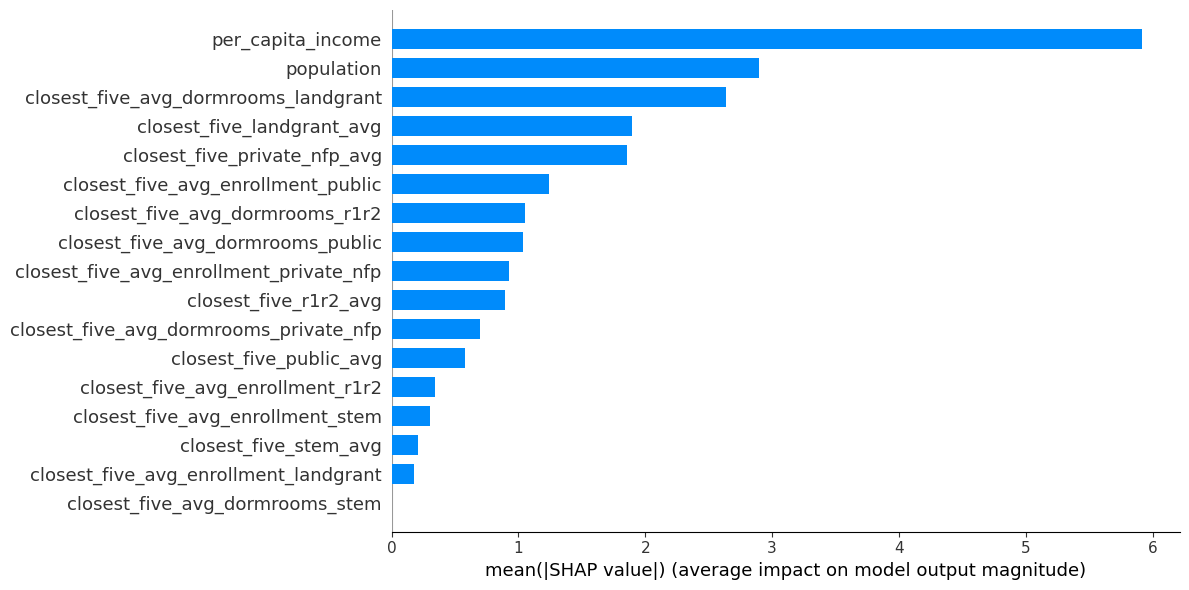

In [41]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
plt.close()

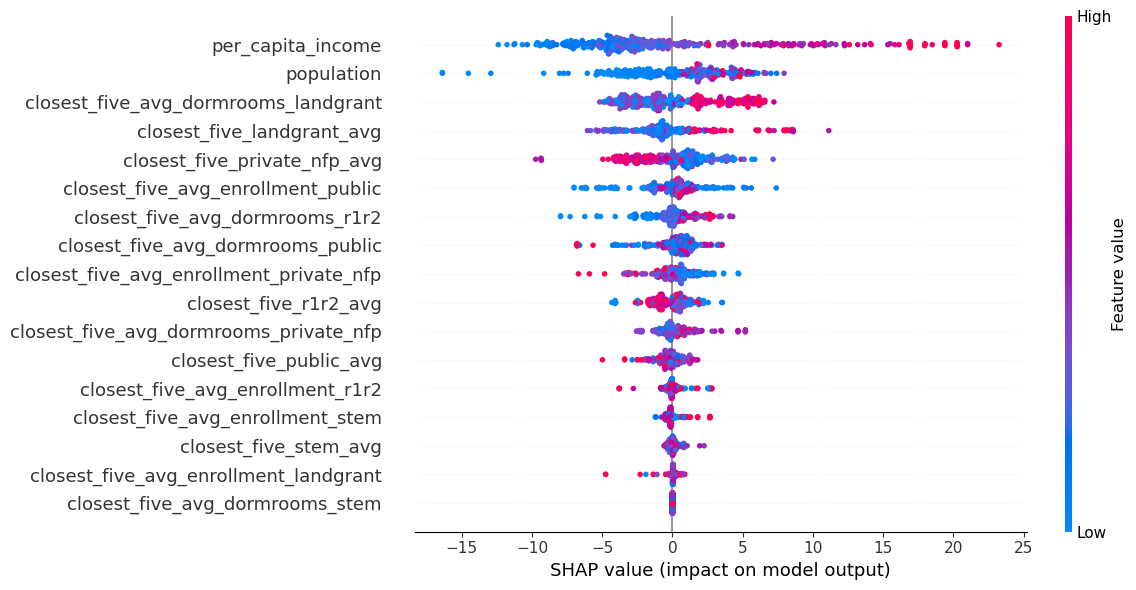

In [42]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
plt.close()